In [24]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error, classification_report,confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeRegressor,export_graphviz,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

import ModelEvaluation as me
from datetime import datetime,timedelta

import os
from db_utils.pg_connect import pg_connect

from IPython.display import display, HTML, Image
from subprocess import call
import gc
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

In [2]:
config_file = os.path.join(os.environ['HOME'], '.databases.conf')
dbu = pg_connect("whatif", config_file)

In [3]:
# TEST THAT EVERYTHING IS WORKING
df = dbu.get_df_from_query("select * from pg_tables limit 5")
df.head(2)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers
0,pg_catalog,systable_topology,rdsdb,None,False,False,False
1,pg_catalog,systable_schema,rdsdb,None,False,False,False


In [4]:
# SET END DATE
date_data_accessed = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
# TIME WINDOW SET IN DAYS, TELLS US HOW MANY DAYS TO GO BACK
lengthtimewindow = -30

# Attrition Data

In [19]:
sql = """
WITH offers_seen AS
(
  SELECT imp.user_session_id,
         imp.num_offers_seen
  FROM tracking.user_impression imp
    INNER JOIN tracking.user_impression_linkout_revenue r ON imp.id = r.user_impression_id
  WHERE imp.created_at::DATE BETWEEN dateadd(days,{0},'{1}') AND '{1}'
),
session_max_offers_seen AS
(
  SELECT user_session_id AS s_id,
         MAX(num_offers_seen) AS offers
  FROM tracking.user_impression
  WHERE created_at::DATE BETWEEN dateadd(days,{0},'{1}') AND '{1}'
  GROUP BY 1
),
linkouts_url AS
(
  SELECT o.name,
         i.offer_id,
         MAX(CASE WHEN CASE WHEN an_l.url IS NULL THEN o.offer_url ELSE an_l.url END IS NULL THEN o.linkout_url ELSE an_l.url END) AS url
  FROM tracking.user_impression i
    INNER JOIN offers o ON o.id = i.offer_id
    LEFT JOIN tracking.user_offer_question_answer qa ON i.id = qa.user_impression_id
    LEFT JOIN offer_question_answer an ON qa.offer_question_answer_id = an.id
    LEFT JOIN offer_question_answer_linkout an_l ON an_l.offer_question_answer_id = an.id
  WHERE i.created_at::DATE BETWEEN dateadd(days,{0},'{1}') AND '{1}'
  GROUP BY 1,
           2
),
linkouts_identify AS
(
  SELECT offer_id AS id,
         CASE
           WHEN url IS NOT NULL THEN 1
           ELSE 0
         END AS is_linkout
  FROM linkouts_url
),
initial_dataset AS
(
  SELECT t1.id AS imp_id,
         t1.user_session_id,
         t1.offer_id,
         t3.name AS offer_name,
         t2.name AS offer_type,
         t1.sequence_id,
         t4.name AS sequence_name,
         t1.order_by,
         CASE
           WHEN t6.offers > t1.num_offers_seen THEN t1.id
           WHEN t7.num_offers_seen IS NULL THEN t1.id
           ELSE NULL
         END AS true_imp_id,
         RANK() OVER (PARTITION BY t1.user_session_id,t1.sequence_id ORDER BY t1.created_at ASC) AS display_order,
         DENSE_RANK() OVER (PARTITION BY t1.sequence_id ORDER BY t1.order_by::INT ASC) AS ranked_order_by,
         t5.is_linkout,
         continued,
         answer,
         tcpa_opt_in_time,
         clicked,
         calculated_revenue
  FROM tracking.user_impression AS t1
    LEFT JOIN public.offer_types AS t2 ON t1.offer_type_id = t2.id
    LEFT JOIN public.offers AS t3 ON t1.offer_id = t3.id
    LEFT JOIN public.sequences AS t4 ON t1.sequence_id = t4.id
    LEFT JOIN linkouts_identify AS t5 ON t1.offer_id = t5.id
    INNER JOIN session_max_offers_seen AS t6 ON t1.user_session_id = t6.s_id
    LEFT JOIN offers_seen AS t7
           ON t1.user_session_id = t7.user_session_id
          AND t1.num_offers_seen - 1 = t7.num_offers_seen
    LEFT JOIN tracking.user_offer_question_answer t8 ON t1.id = t8.user_impression_id
    LEFT JOIN offer_question_answer t9 ON t8.offer_question_answer_id = t9.id
    INNER JOIN tracking.user_session t10 ON t1.user_session_id = t10.id
  WHERE t1.created_at::DATE BETWEEN dateadd(days,{0},'{1}') AND '{1}'
),
final_set AS
(
  SELECT sequence_id,
         offer_id,
         offer_name,
         offer_type,
         --display_order,
         order_by,
         ranked_order_by,
         is_linkout,
         AVG(display_order) AS avg_display_order,
         COUNT(DISTINCT true_imp_id) AS true_impressions,
         COUNT(DISTINCT user_session_id) AS impressions,
         CASE
           WHEN offer_type = 'Question' THEN COUNT(DISTINCT
             CASE
               WHEN answer IN ('Yes','Show Me Now!','Get my samples now!') THEN imp_id
               ELSE NULL
             END )
           ELSE COUNT(DISTINCT
             CASE
               WHEN clicked = 'true' THEN user_session_id
               ELSE NULL
             END )
         END 
         +
         (CASE
            WHEN offer_type NOT IN ('Question','Banner') AND offer_name LIKE '%onfirm%' 
            THEN COUNT(DISTINCT CASE WHEN tcpa_opt_in_time IS NOT NULL THEN user_session_id ELSE NULL END)
            ELSE 0
          END) AS clicks,
         clicks::FLOAT/(CASE WHEN true_impressions = 0 THEN 1 ELSE true_impressions END) as true_ctr,
          1000 *(COALESCE(SUM(calculated_revenue),0)) /(COUNT(DISTINCT imp_id))::FLOAT AS cpm,
          1 -((COUNT(DISTINCT CASE WHEN continued = 'true' THEN user_session_id ELSE NULL END))/(COUNT(DISTINCT user_session_id))::FLOAT) AS attrition
  FROM initial_dataset
  GROUP BY 1,2,3,4,5,6,7
)
SELECT * 
FROM final_set;
""".format(lengthtimewindow,date_data_accessed)
attrition_data = dbu.get_df_from_query(sql)
attrition_data.shape

(15054, 14)

In [20]:
def build_dummies(dataframe,feats):
    df = pd.DataFrame()
    for feat in feats:
        df = pd.concat([df,pd.get_dummies(dataframe[feat],prefix=feat)],axis=1,sort=False)
    df = pd.concat([dataframe,df],axis=1,sort=False)
    df.drop(feats,axis=1,inplace=True)
    return df

def get_cat_features(DF):
    offer_name = DF.filter(regex='^offer_name_+').columns.tolist()
    offer_type = DF.filter(regex='^offer_type_+').columns.tolist()
    cat_feats = offer_name + offer_type
    return cat_feats

def best_params(grid):
    estimator = grid.best_estimator_
    svd = grid.best_estimator_.steps[1][1]
    classifier = grid.best_estimator_.steps[2][1]
    params = grid.best_params_
    score = grid.best_score_
    return estimator,svd,classifier,params,score

class ColumnSelector(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def transform(self, X, y=None):
        return X[self.cols]

    def fit(self, X, y=None):
        return self


class CategoricalColumnSelector(TransformerMixin):
    def __init__(self,feats):
        self.feats = feats

    def transform(self, X, y=None):
        regstr = ''
        length = len(self.feats)
        for i,feat in enumerate(self.feats):
            regstr = regstr+'^'+feat+'_+'
            
            if i < length-1:
                regstr = regstr+'|'
        return X.filter(regex=regstr)

    def fit(self, X, y=None):
        return self

In [21]:
cat_feats = ['offer_name',
             'offer_type']
num_feats = [#'display_order',
           'order_by',
           'ranked_order_by',
           'is_linkout',
           'true_impressions',
           'avg_display_order']
           #'clicks',
           #'true_ctr',
           #'cpm']
features = cat_feats + num_feats
X = build_dummies(attrition_data[features],cat_feats)
y = attrition_data['attrition']

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [23]:
X_train.head(1)

,order_by,ranked_order_by,is_linkout,true_impressions,avg_display_order,offer_name_10K Lead Economy - Linkout,offer_name_10K Lead Economy - Sweeps,offer_name_10K Sweeps - Prequal,offer_name_10k Lead Economy - Revshare,offer_name_10k Lead Economy - SOT,offer_name_1440 Newsletter - Mow Media,offer_name_1800 Dentist - Call Trader - Required,offer_name_3M Earplugs - Consumer AG Pt. 1,offer_name_3M Earplugs - Consumer AG Pt. 2,offer_name_3M Earplugs - Consumer AG Pt. 3 New,offer_name_3M Earplugs - Consumer AG Pt. 4,offer_name_ACG - Clean Return Url,offer_name_ACG DOB STR Phone - Add'l fields,offer_name_ACG Exit Page - Path,offer_name_ACG FormCL,offer_name_ACG LP - Clean,offer_name_ACG LP - Email,offer_name_ACG LP - Email - No PN,offer_name_ACG Offer Wall New,offer_name_ACG Registration Add field,offer_name_ACG Return LP,offer_name_ACG_Registration - Banner,offer_name_ACG_Registration Confirm,offer_name_Achieve Card - Base,offer_name_Acquire Health Medical Card,offer_name_Active Sun Multi,offer_name_Adam Schiff - Required,offer_name_Add fields Test,offer_name_Advisio - Medicare TCPA,offer_name_American Career Guide - ACGQ Return Url,offer_name_Anthony Test Return Url,offer_name_AppleHomePod - MF,offer_name_Auto Accident- Mantra Digital - TCPA Required,offer_name_Auto Insurance - DataLot Required,offer_name_Auto Insurance - Zeta,offer_name_BDE - Add'l Fields,offer_name_BDE Confirm - Required,offer_name_BDE Email Submit,offer_name_BDE Email Submit - NO PUSH,offer_name_BDE Exit Page - Path,offer_name_BDE Instant Win Page 1 - Nitro 1 Day,offer_name_BDE Instant Win Page 1 - post,offer_name_BDE Offer Wall New,offer_name_BDE Q - GAPC,offer_name_BDE Return Url,offer_name_BLC Banner,offer_name_BLC Banner Weekend,offer_name_BLC Banner Weekend AT,offer_name_Back Brace - OptIntelligence,offer_name_Bankers Life Insurance - OptIntelligence - Required,offer_name_Baseball PreQual,offer_name_Ben Question Test,offer_name_Ben test Return Url,offer_name_Ben test1 Return Url,offer_name_Better Health Kare - Required,offer_name_Bishamon Media - Refi Linkout CPC,offer_name_Bishamon Media - Refi Linkout CPC Target,offer_name_BizOpp AIB - Required,offer_name_BloodClot/IVC - Strategic Decisions Group,offer_name_Buying Online,offer_name_C2W - Add'l Fields,offer_name_C2W - Add'l Fields New,offer_name_C2W - Add'l Fields Pre,offer_name_C2W Confirm,offer_name_C2W Email,offer_name_C2W Email - GG,offer_name_C2W Email no PN,offer_name_C2W Offer Wall New,offer_name_C2W Q - GAPC,offer_name_C4R - C4RS2 Return Url,offer_name_C4R - Door Return Url,offer_name_C4R - Finalist Return Url,offer_name_C4R Confirm,offer_name_C4R Confirm TEST,offer_name_C4R Offer Wall New,offer_name_C4R Return LP,offer_name_C4R Return LP - SweepZilla BDay,offer_name_C4R Return LP - WL Retarget 1,offer_name_C4R Slide - Add'l Fields,offer_name_C4R Slide - Add'l Fields 1,offer_name_C4R Slide - Email No Arca,offer_name_C4R Slide - Email w/Arca,offer_name_CAG - Cash Return Url,offer_name_CAG - Check Return Url,offer_name_CAG - Clean Return Url,offer_name_CAG - Final Notice Return Url,offer_name_CAG AddlxTCPA New,offer_name_CAG AddlxTCPA Pre,offer_name_CAG Confirm - Required,offer_name_CAG Email - Test,offer_name_CAG Email gg,offer_name_CAG Email w/Arca,offer_name_CAG FB Jump,offer_name_CAG FormCL,offer_name_CAG Offer Wall New,offer_name_CAG Return LP,offer_name_CAG Slide - Add'l Fields,offer_name_CAG Slide - Add'l Fields New,offer_name_CAG Slide - Add'l Fields Pre,offer_name_Cancer Screening Kit - Converzate Required,offer_name_Car Owner - PreQual,offer_name_Celebrity Cruises - Permission Data,offer_name_CenturyLink - Clearlink Drips - Required,offer_name_Checking Account - FD - ERD,offer_name_Checking Account - FD - UO,offer_name_Checking Account - Full Data,offer_name_Checking Acct + Ad,offer_name_Class Action Guide Return Url,offer_name_Click N Lend - BMA DYN Prequal,offer_name_Click2Win Return Url,offer_name_Clinical Trials - Subjectwell - Required,offer_name_CollegeEducationInfo - Ventrix - E targ

# PCA

Text(0, 0.5, 'explained_variance_')

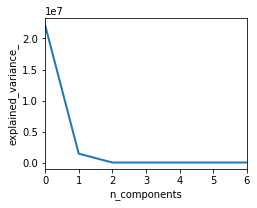

In [59]:
union = FeatureUnion([
        ('numeric_feats',ColumnSelector(cols=num_feats)),
        ('categorical_feats',CategoricalColumnSelector(feats=cat_feats))
    ])
pca_pipe = Pipeline([
    ('features',FeatureUnion([
        ('numeric_feats',ColumnSelector(cols=num_feats)),
        ('categorical_feats',CategoricalColumnSelector(feats=cat_feats))
    ])),
    ('pca',PCA(random_state=42))
])
pca_pipe.fit(X_train)
plt.figure(1,figsize=(4, 3))
plt.axes([.2, .2, .7, .7])
plt.plot(pca_pipe.named_steps['pca'].explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlim(0,6)
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# pipline

In [10]:
n_components = [1,2]
param_grid = [{'svd__n_components': n_components,
               'clf__max_depth':[1,2,3,4,5,None],
               'clf__oob_score':[False,True]}
        ]
pipe = Pipeline([
    ('features',FeatureUnion([
        ('numeric_feats',ColumnSelector(cols=num_feats)),
        ('categorical_feats',Pipeline([
            ('categories',ColumnSelector(cols=get_cat_features(X_train))),
            ('encoder',OneHotEncoder(handle_unknown='ignore')),
        ]))
    ])),
    ('svd',TruncatedSVD(random_state=42)),
    ('clf',RandomForestRegressor(random_state=42,
                                 max_features='auto',
                                 criterion='mse',
                                 n_estimators=50))
])

In [11]:
gs_dt = GridSearchCV(pipe,
                    param_grid,
                    scoring='explained_variance',
                    return_train_score=True,
                    cv=5,n_jobs=3,verbose=1,error_score='raise')
gs_dt.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  5.5min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed: 17.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric_feats', <__main__.ColumnSelector object at 0x7f5039386c18>), ('categorical_feats', Pipeline(memory=None,
     steps=[('categories', <__main__.ColumnSelector object at 0x7f503ed392b0>), ('encoder', OneHotEncoder(categori...imators=50, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid=[{'svd__n_components': [1, 2], 'clf__max_depth': [1, 2, 3, 4, 5, None], 'clf__oob_score': [False, True]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='explained_variance', verbose=1)

In [12]:
estimator,svd,dtree,params,score = best_params(gs_dt)

In [13]:
score

0.30298197080701306

# Evaluation

In [14]:
def RegModelEval(df,training=False,n=100):
    y_train = df.attrition
    y_train_pred = df.pred_att_train
    y_test = df.attrition
    y_test_pred = df.pred_att_test
    print('R^2 Test: {:.5f}'.format(r2_score(y_test,y_test_pred)))
    print('MSE Test: {:.5f}'.format(mean_squared_error(y_test,y_test_pred)))
    plt.rcParams['figure.figsize'] = (8, 8)
    
    if training:
        print('R^2 Train: {:.5f}'.format(r2_score(y_train,y_train_pred)))
        print('MSE Train: {:.5f}'.format(mean_squared_error(y_train,y_train_pred)))
        plt.scatter(y_train_pred[:n],(y_train_pred[:n]-y_train[:n]),
                    c='blue',
                    label='Training_data',
                    marker='o',s=10**2)
    
    plt.scatter(y_test_pred[:n],(y_test_pred[:n]-y_test[:n]),c='lightgreen',marker='s',label='Test_data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
    plt.xlim([-1,1])
    plt.show()

In [15]:
pred = estimator.predict(X_test)
pred_df = pd.DataFrame(list(zip(X_test.index,pred)),columns=['id','pred_att_test'])
eval_df_test = pred_df.merge(attrition_data[features+['attrition']],right_index=True,left_on='id')

In [16]:
pred = estimator.predict(X_train)
pred_df = pd.DataFrame(list(zip(X_train.index,pred)),columns=['id','pred_att_train'])
eval_df_train = pred_df.merge(attrition_data[features+['attrition']],right_index=True,left_on='id')

In [17]:
eval_df = eval_df_test.merge(eval_df_train,on=features+['attrition'])

R^2 Test: 0.66888
MSE Test: 0.03576
R^2 Train: 0.66888
MSE Train: 0.03576


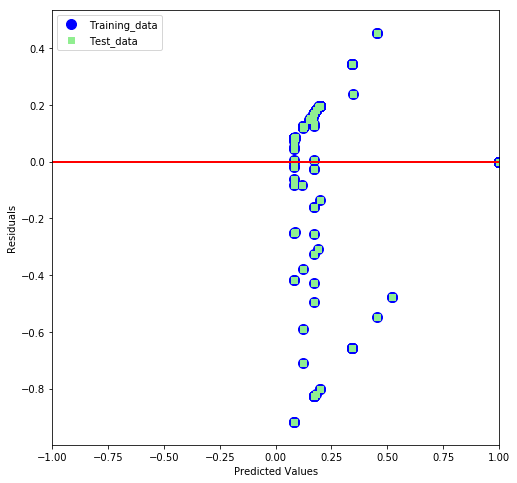

In [18]:
RegModelEval(eval_df,training=True,n=1000)